In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import sklearn
import itertools
from tensorflow_addons.optimizers import CyclicalLearningRate
import matplotlib as mpl
mpl.style.use('seaborn')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from tensorflow.keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers


%matplotlib inline

In [5]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mitbit-arrhythmia-database/mitbih_database/112annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/233.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/108.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/118annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/231.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/207.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/115annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/108annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/123annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/102annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/209.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/203annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/202annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/215annotat

In [6]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [21]:
path = '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

In [22]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [23]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    elif(file_extension == '.txt'):
        annotations.append(path + filename + file_extension)

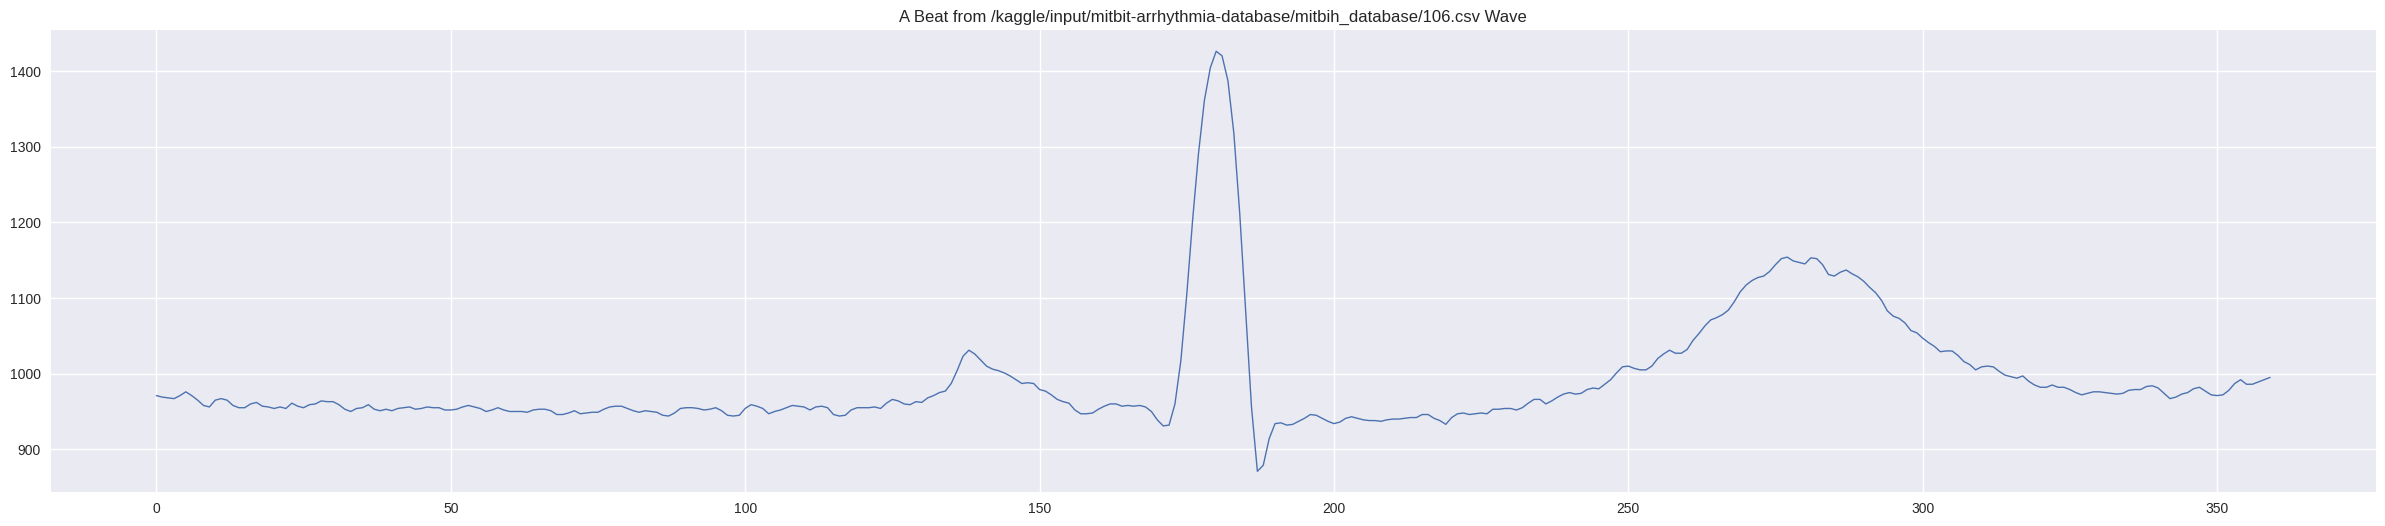

(100012, 360) (100012,)


In [24]:
# Records

X = list()
y = list()

for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                #print(row[1])
                signals.insert(row_index, int(float(row[1])))
            row_index += 1
            
    ''' # Plot an example to the signals
    if r == 6:
        # Plot each patient's signal
        plt.title(records[6] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
    signals = denoise(signals)
    # Plot an example to the signals
    if r == 6:
        # Plot each patient's signal
        plt.title(records[6] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r == 6:
        # Plot each patient's signal
        plt.title(records[6] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    '''
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ') #The split() method splits a string into a list.
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
           # if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                #    pass
            #else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r == 6 and not example_beat_printed: 
                        plt.title("A Beat from " + records[6] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

In [25]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


0    75011
1     8071
2     7255
4     7129
3     2546
Name: 360, dtype: int64


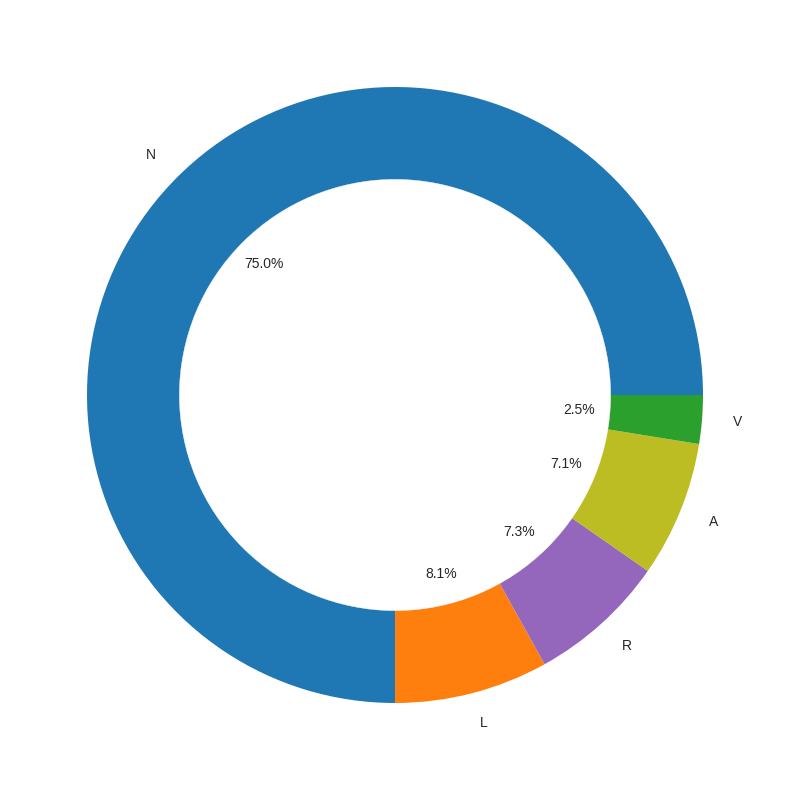

In [26]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(30,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [27]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (80009, 361)
X_test  :  (20003, 361)


In [28]:
# train shape = 20000 * 361
# 361 rows and 20000 columns

target_train=train[train.shape[1]-1]

#target_train size is (20000,)


target_test=test[test.shape[1]-1]

#target_test size is 50000


train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(80009, 5) (20003, 5)


In [29]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(80009, 360, 1) (20003, 360, 1)


In [30]:
mitbih_test = test
mitbih_train = train

In [31]:

mitbih_labels = {'N': 0, 'L': 1, 'R': 2, 'A': 3, 'V': 4}
mitbih_reverse_labels = {v:k for k,v in mitbih_labels.items()}
mitbih_train_labels = mitbih_train.iloc[:,-1].replace(mitbih_reverse_labels)
     

Text(0.5, 1.0, 'Distribution of labels in MIT-BIH Arhythmia dataset')

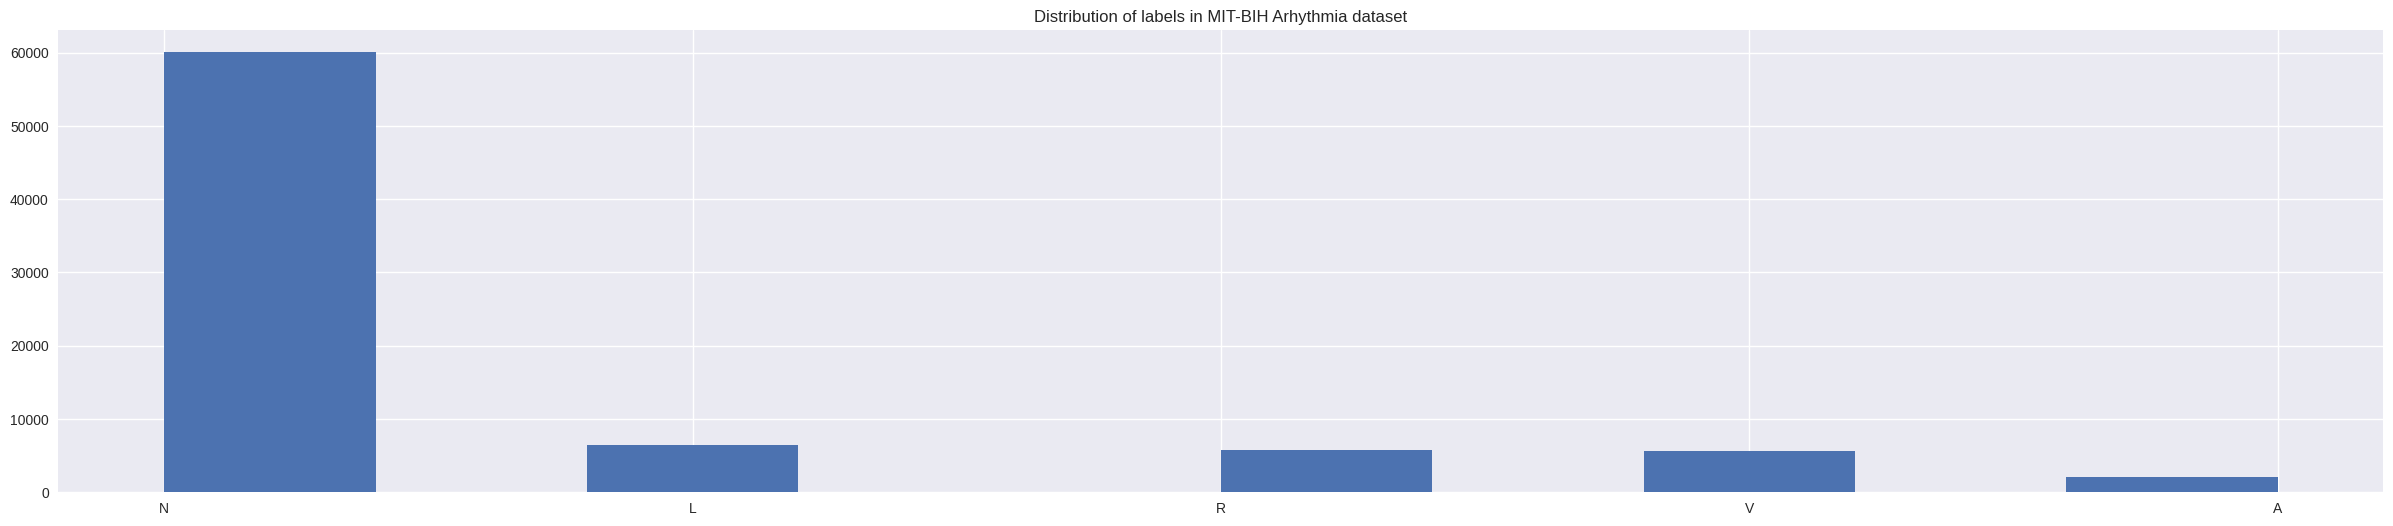

In [32]:
plt.hist(mitbih_train_labels)
plt.title("Distribution of labels in MIT-BIH Arhythmia dataset")

### Helper 

In [33]:

from tensorflow.keras.callbacks import Callback

class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [34]:
def pretty_plot(history, field, fn):
    def plot(data, val_data, best_index, best_value, title):
        plt.plot(range(1, len(data)+1), data, label='train')
        plt.plot(range(1, len(data)+1), val_data, label='validation')
        if not best_index is None:
            plt.axvline(x=best_index+1, linestyle=':', c="#777777")
        if not best_value is None:
            plt.axhline(y=best_value, linestyle=':', c="#777777")
        plt.xlabel('Epoch')
        plt.ylabel(field)
        plt.xticks(range(0, len(data), 20))
        plt.title(title)
        plt.legend()
        plt.show()
        
    data = history.history[field]
    val_data = history.history['val_' + field]
    tail = int(0.15 * len(data))
    best_index = fn(val_data)
    best_value = val_data[best_index]
    plot(data, val_data, best_index, best_value, "{} over epochs (best {:06.4f})".format(field, best_value))
    plot(data[-tail:], val_data[-tail:], None, best_value, "{} over last {} epochs".format(field, tail))

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
X_mitbih_train, X_mitbih_val, y_mitbih_train, y_mitbih_val = train_test_split(mitbih_train.iloc[:,:-1].values, mitbih_train.iloc[:,-1].values, test_size=0.1, random_state=42)
X_mitbih_test = mitbih_test.iloc[:,:-1].values
y_mitbih_test = mitbih_test.iloc[:,-1].values

In [37]:
# The 1D convolutions expect an extra dimension in the input data 
X_mitbihl_train = np.expand_dims(X_mitbih_train, -1)
y_mitbihl_train = np.expand_dims(y_mitbih_train, -1)
X_mitbihl_val = np.expand_dims(X_mitbih_val, -1)
y_mitbihl_val = np.expand_dims(y_mitbih_val, -1)
X_mitbihl_test = np.expand_dims(X_mitbih_test, -1)
y_mitbihl_test = np.expand_dims(y_mitbih_test, -1)

In [38]:
def get_base_model(categories=2):
    return keras.Sequential([
    keras.layers.Dense(15, activation='relu', input_shape=[187], kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dense(5, activation='relu'),
    (keras.layers.Dense(1, activation='sigmoid') if categories == 2 else keras.layers.Dense(5, activation='softmax'))                   
  ])

In [39]:
def get_alexnet_model(categories=2):

    inputs = keras.layers.Input([360,1])
    kernels = 32
    stride = 5
    X = keras.layers.Conv1D(kernels, stride)(inputs)
    
    
    # Convolutional block 1
    out = keras.layers.Conv1D(kernels, strides = 4, padding='same',kernel_size = 3)(X) #conv1
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(5, 2)(out) #max pooling 1
     
    # Convolutional block 2
    out = keras.layers.Conv1D(kernels, strides = 1, padding = 'same', kernel_size = 3)(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(5, 2)(out) #max pooling 2
    
    # Convolutional block 3
    out = keras.layers.Conv1D(kernels, strides = 1, padding='same', kernel_size = 3)(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, strides = 1, padding='same', kernel_size = 3)(out)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, strides = 1, padding='same', kernel_size = 3)(out)
    out = keras.layers.ReLU()(out)    
    out = keras.layers.MaxPool1D(5, 2)(out) #max pooling 3
    
    
    out = keras.layers.Flatten()(out)
    out = keras.layers.Dropout(0.5)(out) #dropout 1
                           
    out = keras.layers.Dense(4096, activation='relu')(out)  #fully connected 1
    out = keras.layers.Dropout(0.5)(out) #dropout 2 
    
    out = keras.layers.Dense(4096, activation='relu')(out) #fully connected 2
                           
    out = keras.layers.Dense(1000, activation='softmax')(out) #fully connected 3
                           
#     out = keras.layers.Dense(32, activation='relu')(out)
#     out = keras.layers.Dense(32, activation='relu')(out)
    output = (keras.layers.Dense(1, activation='sigmoid')(out) if categories == 2 else keras.layers.Dense(5, activation='softmax')(out))

    model = keras.Model(inputs=inputs, outputs=output)

    return model


In [40]:
N = mitbih_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-5, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
m_alexnet_model = get_alexnet_model(5)

save_alexnet_weights = ModelCheckpoint(filepath="weights_alexnet.hdf5", verbose=0, save_best_only=True)

m_alexnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_alexnet = m_alexnet_model.fit(X_mitbihl_train, y_mitbihl_train, validation_data=(X_mitbihl_val, y_mitbihl_val), 
                             shuffle=True, batch_size=128, epochs=30, callbacks=[save_alexnet_weights])

Epoch 1/30
563/563 [==============================] - 243s 428ms/step - loss: 1.4635 - accuracy: 0.7406 - val_loss: 1.3140 - val_accuracy: 0.7474
Epoch 2/30
563/563 [==============================] - 238s 423ms/step - loss: 1.1321 - accuracy: 0.7510 - val_loss: 0.9920 - val_accuracy: 0.7474
Epoch 3/30
563/563 [==============================] - 241s 429ms/step - loss: 0.9316 - accuracy: 0.7510 - val_loss: 0.9137 - val_accuracy: 0.7474
Epoch 4/30
563/563 [==============================] - 239s 424ms/step - loss: 0.9002 - accuracy: 0.7510 - val_loss: 0.9053 - val_accuracy: 0.7474
Epoch 5/30
563/563 [==============================] - 237s 422ms/step - loss: 0.8962 - accuracy: 0.7510 - val_loss: 0.9037 - val_accuracy: 0.7474
Epoch 6/30
563/563 [==============================] - 237s 420ms/step - loss: 0.8934 - accuracy: 0.7510 - val_loss: 0.9001 - val_accuracy: 0.7474
Epoch 7/30
563/563 [==============================] - 238s 423ms/step - loss: 0.8903 - accuracy: 0.7510 - val_loss: 0.8982 -

In [62]:
m_alexnet_model.load_weights('weights_alexnet.hdf5')
X_mitbih_test = m_alexnet_model.evaluate(X_mitbihl_test, y_mitbihl_test)

626/626 [==============================] - 17s 27ms/step - loss: 0.8955 - accuracy: 0.7477


626/626 [==============================] - 16s 26ms/step
Confusion matrix, without normalization
[[14956     0     0     0     0]
 [ 1647     0     0     0     0]
 [ 1437     0     0     0     0]
 [  495     0     0     0     0]
 [ 1468     0     0     0     0]]


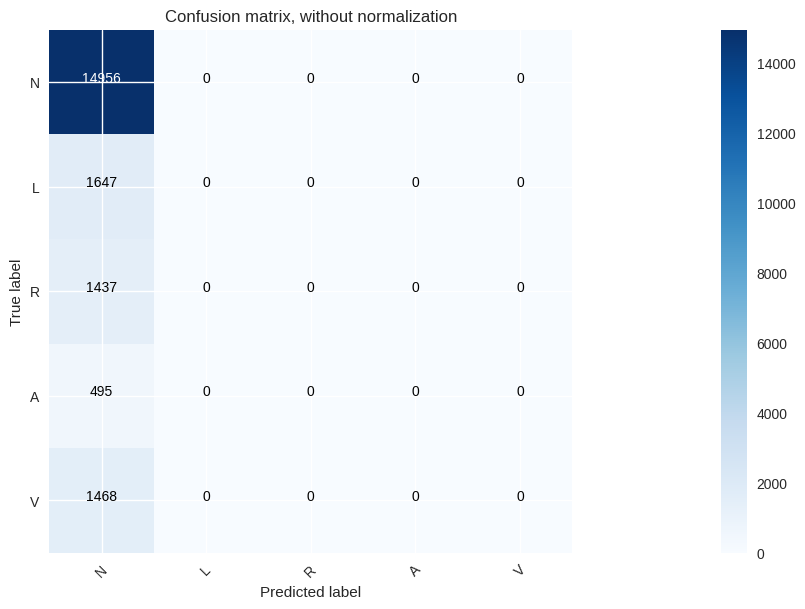

In [63]:
y_pred1 = tf.argmax(m_alexnet_model.predict(X_mitbihl_test), axis=-1)
# Compute confusion matrix
cnf_matrix1 = sklearn.metrics.confusion_matrix(y_mitbih_test, y_pred1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=['N', 'L', 'R', 'A', 'V'],
                      title='Confusion matrix, without normalization')

In [64]:
from sklearn.metrics import roc_auc_score
y_pred_proba = m_alexnet_model.predict_on_batch(X_mitbihl_test)
roc_auc_score(y_mitbih_test, y_pred_proba, multi_class='ovr')

0.5000210509882597

In [65]:
m_alexnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 360, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 356, 32)           192       
                                                                 
 conv1d_1 (Conv1D)           (None, 89, 32)            3104      
                                                                 
 re_lu (ReLU)                (None, 89, 32)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 43, 32)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 43, 32)            3104      
                                                             

In [66]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
label_encoder.fit(y)
y=label_encoder.transform(y)
classes=label_encoder.classes_

In [67]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


In [68]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc

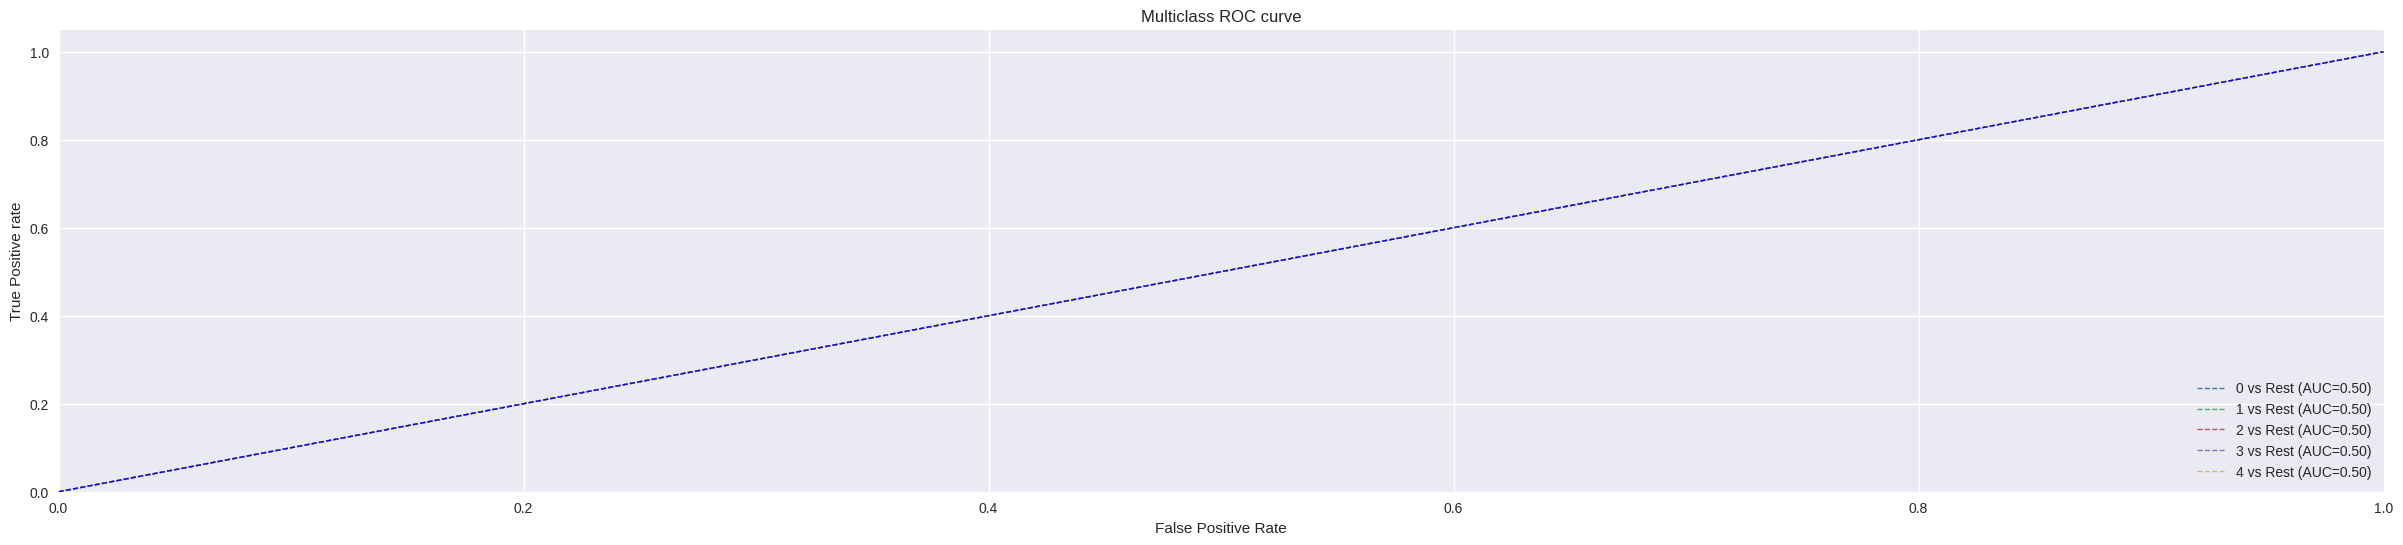

In [69]:
from sklearn.preprocessing import label_binarize
#binarize the y_values

y_test_binarized=label_binarize(y_mitbihl_test,classes=np.unique(y_mitbihl_test))

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = classes.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], y_pred_proba[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()